<a href="https://colab.research.google.com/github/NaHyeonMaeng/CODE_Practice/blob/main/%EA%B0%9C_%EA%B3%A0%EC%96%91%EC%9D%B4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

In [2]:
#구글 드라이브 폴더 마운트
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
#압축된 파일 위치
drive_path = "/content/drive/MyDrive"
source_filename = drive_path + "/cat-and-dog.zip"

#저장할 경로
extract_folder = "dataset/"  #코랩 환경에 임시 저장

#압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [4]:
#훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + "archive/training_set/training_set"
valid_dir = extract_folder + "archive/test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/archive/training_set/training_set
dataset/archive/test_set/test_set


In [5]:
#이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale = (1/255.))
image_gen

In [6]:
#flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정의
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size = 32,
                                          target_size = (244, 244),  #사용할 cnn 모델 입력 사이즈에 맞게 resize
                                          classes = ['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)
valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size = 32,
                                          target_size = (244, 244),  #사용할 cnn 모델 입력 사이즈에 맞게 resize
                                          classes = ['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed = 2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-7-1836dd736982>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


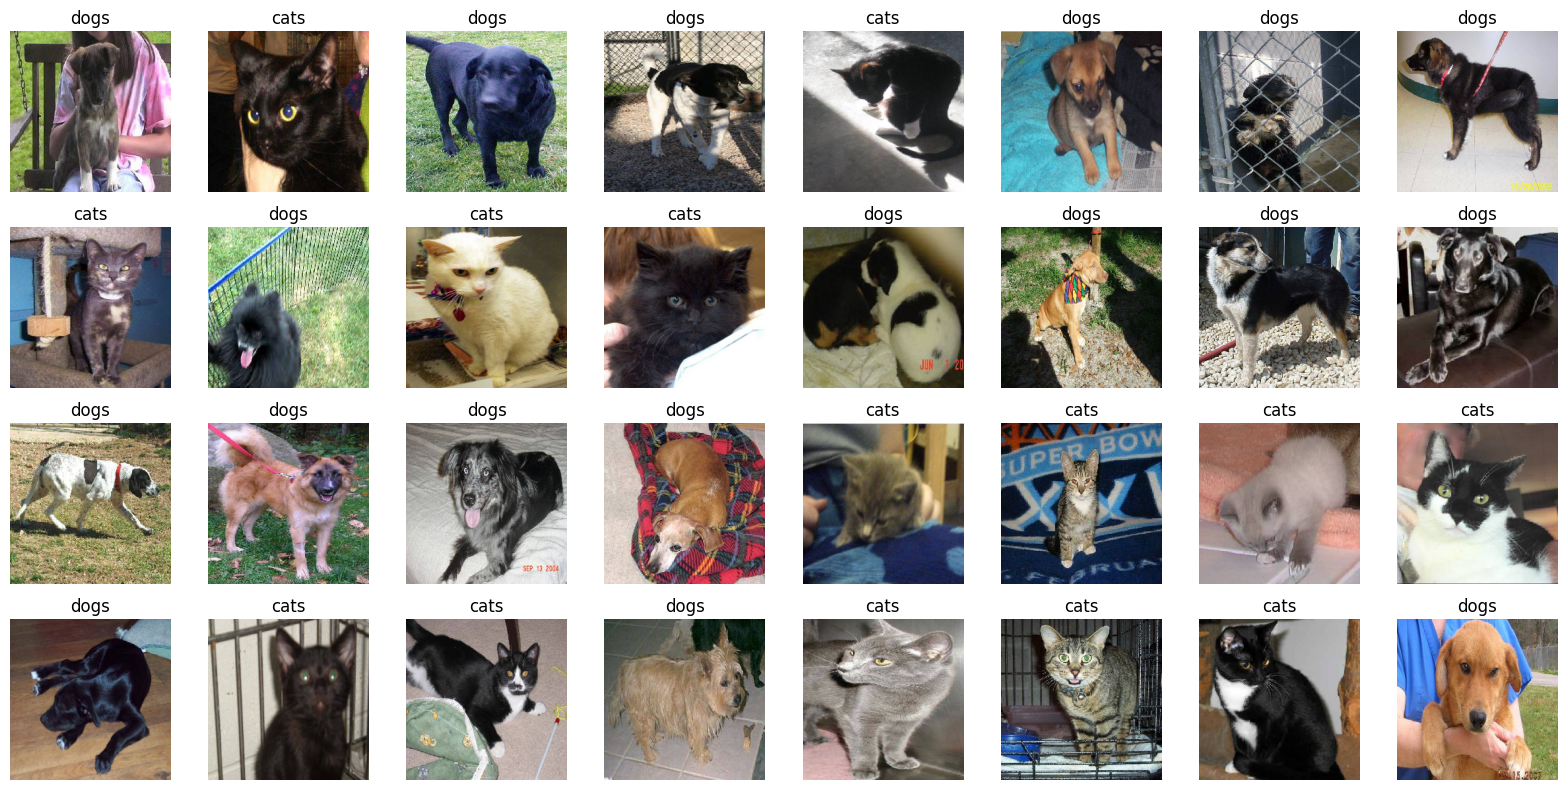

In [7]:
#샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

  ax = plt.subplot(4, 8, i+1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis("off")

plt.tight_layout()
plt.show()

In [33]:
#Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([
      #Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128,(3,3), padding = 'same', activation = 'relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

  return model

model = build_model()

In [9]:
#모델 컴파일
model.compile(optimizer = tf.optimizers.Adam(lr=0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = ['accuracy'])

#모델 훈련
history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

Epoch 1/20
251/251 [==============================] - 52s 179ms/step - loss: 2.4552 - accuracy: 0.5640 - val_loss: 0.6673 - val_accuracy: 0.6179
Epoch 2/20
251/251 [==============================] - 46s 183ms/step - loss: 0.6550 - accuracy: 0.5923 - val_loss: 0.6334 - val_accuracy: 0.6322
Epoch 3/20
251/251 [==============================] - 43s 169ms/step - loss: 0.6319 - accuracy: 0.6041 - val_loss: 0.6054 - val_accuracy: 0.6624
Epoch 4/20
251/251 [==============================] - 42s 168ms/step - loss: 0.6223 - accuracy: 0.6244 - val_loss: 0.6202 - val_accuracy: 0.6550
Epoch 5/20
251/251 [==============================] - 41s 164ms/step - loss: 0.6019 - accuracy: 0.6392 - val_loss: 0.5966 - val_accuracy: 0.6698
Epoch 6/20
251/251 [==============================] - 43s 171ms/step - loss: 0.5966 - accuracy: 0.6516 - val_loss: 0.5906 - val_accuracy: 0.6520
Epoch 7/20
251/251 [==============================] - 41s 164ms/step - loss: 0.5813 - accuracy: 0.6556 - val_loss: 0.5350 - val_ac

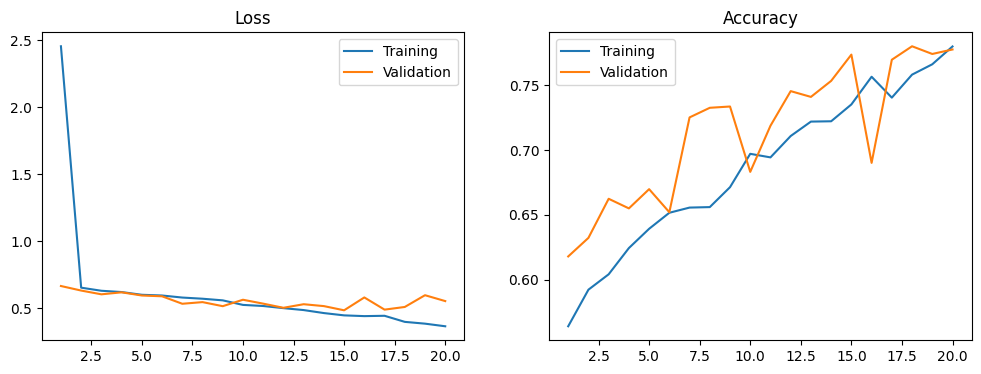

In [10]:
#손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):

  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

  fig, axes = plt.subplots(1, 2, figsize = (12, 4))

  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc = 'best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch + 1), acc, label = 'Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label = 'Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

plot_loss_acc(history, 20)

데이터 증강

In [40]:
#이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale = 1/255.,
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   shear_range = 0.15,
                                   zoom_range = 0.3)

#flow_from_direcotory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (244, 244),  #사용할 cnn 모델 입력 사이즈에 맞게 resize
                                              classes = ['cats', 'dogs'],
                                              class_mode = 'binary',
                                              seed = 2020)

valid_gen_aug = image_gen.flow_from_directory(valid_dir,
                                              batch_size = 32,
                                              target_size = (244, 244),  #사용할 cnn 모델 입력 사이즈에 맞게 resize
                                              classes = ['cats', 'dogs'],
                                              class_mode = 'binary',
                                              seed = 2020)

#모델 생성
model_aug = build_model()

#모델 컴파일
model_aug.compile(optimizer = tf.optimizers.Adam(lr=0.001),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics = ['accuracy'])

#모델 훈련
histoy_aug = model_aug.fit(train_gen_aug, validation_data = valid_gen_aug, epochs = 20)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


Epoch 1/20
251/251 [==============================] - 46s 171ms/step - loss: 2.7708 - accuracy: 0.5850 - val_loss: 0.6609 - val_accuracy: 0.6396
Epoch 2/20
251/251 [==============================] - 42s 168ms/step - loss: 0.6289 - accuracy: 0.6297 - val_loss: 0.5878 - val_accuracy: 0.6960
Epoch 3/20
251/251 [==============================] - 46s 184ms/step - loss: 0.6076 - accuracy: 0.6506 - val_loss: 0.5705 - val_accuracy: 0.6886
Epoch 4/20
251/251 [==============================] - 42s 169ms/step - loss: 0.5779 - accuracy: 0.6730 - val_loss: 0.5484 - val_accuracy: 0.7133
Epoch 5/20
251/251 [==============================] - 41s 165ms/step - loss: 0.5556 - accuracy: 0.6831 - val_loss: 0.5247 - val_accuracy: 0.7341
Epoch 6/20
251/251 [==============================] - 43s 170ms/step - loss: 0.5505 - accuracy: 0.7129 - val_loss: 0.5672 - val_accuracy: 0.7168
Epoch 7/20
251/251 [==============================] - 42s 165ms/step - loss: 0.5286 - accuracy: 0.7267 - val_loss: 0.5381 - val_ac

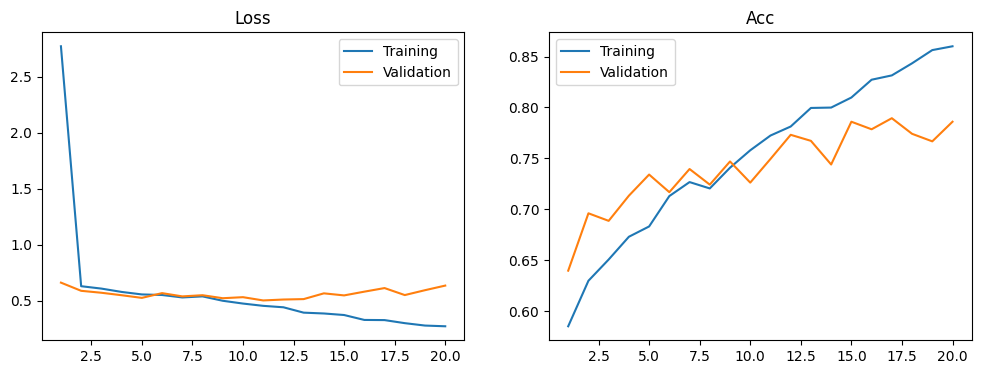

In [41]:
#손실함수, 정확도, 그래프 그리기
plot_loss_acc(histoy_aug, 20)